In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
def find_root(a):
    u = np.sort(np.abs(a))[::-1]
    k = np.arange(1, len(u)+1)
    K_ = []
    for ik in k:
        if np.sum(u[:ik])-1<u[ik-1]*ik:
            K_.append(ik)
    K = np.max(K_)
    return (1/K)*(np.sum(u[:K])-1)


array([3, 2, 1])

In [269]:
def test_root(a, root):
    return np.sum(np.maximum(np.abs(a)-root,0))-1
    
v = np.random.uniform(1,2,size=200) # random vector of size 200 between [1,2]
root = find_root(v)
print('root: ',root)
print('error: ', test_root(v, root))


root:  1.8922658661181042
error:  4.440892098500626e-15


In [899]:
def find_root(a):
    u = np.sort(np.abs(a))[::-1]
    k = np.arange(1, len(u)+1)
    K_ = []
    for ik in k:
        if np.sum(u[:ik])-1<u[ik-1]*ik:
            K_.append(ik)
    K = np.max(K_)
    return (1/K)*(np.sum(u[:K])-1)



def project(v):
    return np.sign(v)*np.maximum(np.abs(v)-find_root(v), 0)
        

def pgd(df, init_vec, lr=0.01, threshold=0.0001, max_iter=100):
        error = [1]
        u = [init_vec]
        v = u
        i = 0
        while error[-1]>threshold:
            v.append(u[-1]-lr*df(u[-1]))
            if np.linalg.norm(v[-1])<=1:
                u.append(v[-1])
            else:
                u.append(project(v[-1]))
            error.append(np.linalg.norm(df(u[-1])))
            i += 1
            if i>=max_iter:
                print(f"Stopping after {i} iterations")
                break
        return u[-1], error[1:]

def FWgd_step(k, df, u, lr=0.1):
    grad_u = df(u)
    max_grad_idx = np.argmax(np.abs(grad_u))
    max_grad_u = lr*np.sign(-grad_u[max_grad_idx])
    update = -u
    update[max_grad_idx] += max_grad_u 
    gamma = 2/(k+1)
    u = u+update*gamma
    return u
    
def FWgd(df, init_vec, lr=1, threshold=0.0001, max_iter=1000):
        error = [1]
        u = [init_vec]
        v = u
        i = 0
        while error[-1]>threshold:
            u.append(FWgd_step(i, df, u[-1], lr))
            error.append(np.linalg.norm(df(u[-1])))
            i += 1
            if i>=max_iter:
                print(f"Stopping after {i} iterations")
                break
        return u[-1], error[1:]

Stopping after 100 iterations
[-1. -0.]


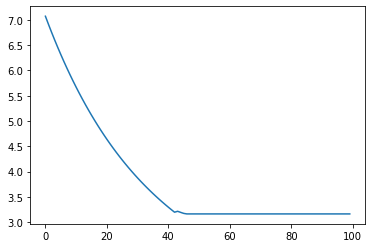

In [900]:
f = lambda x: x@x-x[0]*(x[1]-1)
df = lambda x: np.array([2*x[0]-x[1]+5, -x[0]+2*x[1]])
opt,error = pgd(df, np.array([2,0.5]))
print(opt)
plt.plot(error)

Stopping after 100 iterations
[-1. -0.]


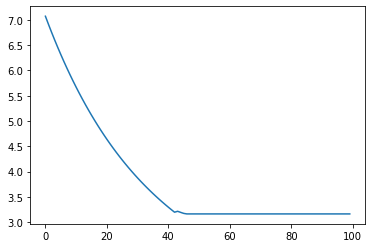

In [782]:
opt,error = pgd(df, np.array([2,0.5]))
print(opt)
plt.plot(error)

In [992]:
def l1norm(v):
    return np.sum(np.abs(v))

def pgd_step(k, df, u, lr=0.01):
    # lr = 2/(k+1)
    v = u-lr*df(u)
    if l1norm(v)<=1:
        u = v
    else:
        u = project(v)
    return u
    
def FWgd_step(k, df, u, lr=1):
    grad_u = df(u)
    # lr = 2/(k+1)
    max_grad_idx = np.argmax(np.abs(grad_u))
    max_grad_u = np.sign(-grad_u[max_grad_idx])
    update = -u
    update[max_grad_idx] += max_grad_u 
    u = u+update*lr
    return u

class LinearRegression:
    def __init__(self, optimizer=None, lr=0.005, r=1, n_iter=200):
        self.lr = lr
        self.optimizer = optimizer
        self.fitted = False
        self.r = r
        self.n_iter = n_iter
        self.loss = []
        self.error = []
        
    def fit(self, X, y):        
        self.beta = np.zeros(X.shape[0])
        df = lambda b: (1/X.shape[1])*X@(X.T@b/self.r-y)
        for i in range(0, self.n_iter):
            self.beta = self.optimizer(i, df, self.beta, lr=self.lr)
            self.loss.append(np.linalg.norm(y-X.T@self.beta)**2/X.shape[1])
        self.beta *=self.r
        self.fitted = True
    
    def predict(self, X):
        if self.fitted:
            return X.T@self.beta
        else:
            print("Model not fitted")

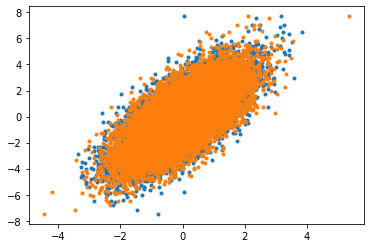

In [1011]:
from scipy.sparse import random
from scipy import stats
# rvs = stats.poisson(25, loc=10).rvs
n_feature, n_data = 1000, 10000
X = np.random.normal(size=[n_feature, n_data])
beta = np.zeros(n_feature)
beta[0] = 1.4
beta[-1] = 1.4 
y = X.T@beta+np.random.normal(size=[n_data])*0.2
plt.plot(X[0,:], y, '.')
# plt.plot(X[int(n_feature/2),:], y, '.')
plt.plot(X[-1,:], y, '.')

In [1017]:
from sklearn.metrics import r2_score
LRp = LinearRegression(lr=0.05, optimizer=pgd_step,r=2.5)
LRp.fit(X, y)
LRfw = LinearRegression(lr=0.05, optimizer=FWgd_step,r=2.5)
LRfw.fit(X, y)
print("Projective GD")
print(r2_score(y, LRp.predict(X)))
print("Projective FW GD")
print(r2_score(y, LRfw.predict(X)))

Projective GD
0.9786392807524775
Projective FW GD
0.9781468683292986


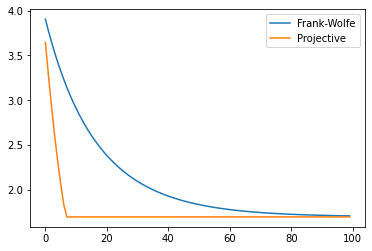

In [1018]:
LRfw = LinearRegression(lr=0.05, optimizer=FWgd_step,r=2.5, n_iter=100)
LRfw.fit(X, y)
plt.plot(LRfw.loss, label="Frank-Wolfe")
LRp = LinearRegression(lr=0.05, optimizer=pgd_step,r=2.5, n_iter=100)
LRp.fit(X, y)
plt.plot(LRp.loss, label="Projective")
plt.legend()

Wall time: 14 ms


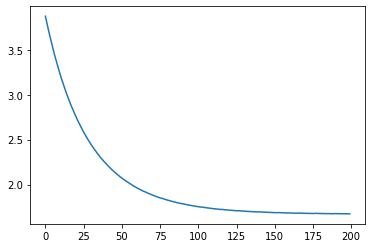

In [969]:
%%time
LRfw = LinearRegression(lr=0.03, optimizer=FWgd_step,r=2.5)
LRfw.fit(X, y)
plt.plot(LRfw.loss)

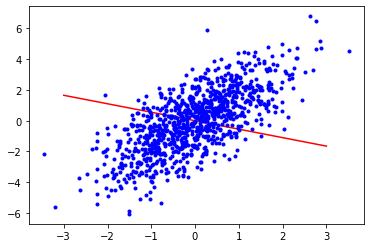

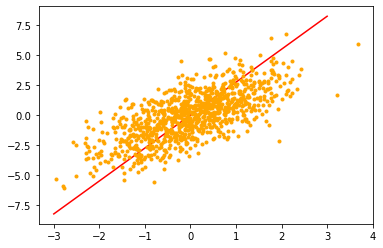

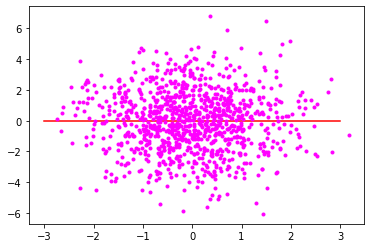

In [968]:
x = np.linspace(-3, 3, 100)
plt.figure()
plt.plot(x, x*LRfw.beta[-1] , 'r')
plt.plot(X[-1,:], y, 'b.')
plt.figure()
plt.plot(x, x*LRfw.beta[0] ,'r')
plt.plot(X[0,:], y, '.', color='orange');
plt.figure()
plt.plot(x, x*LRfw.beta[2] ,'r')
plt.plot(X[2,:], y, '.', color='magenta');

In [937]:
def FWgd(df, init_vec, lr=0.01, threshold=0.0001, max_iter=100):
        error = [1]
        u = [init_vec]
        v = u
        i = 0
        while error[-1]>threshold:
            v.append(u[-1]-lr*df(u[-1]))
            if np.linalg.norm(v[-1])<=1:
                u.append(v[-1])
            else:
                u.append(project(v[-1]))
            error.append(np.linalg.norm(df(u[-1])))
            i += 1
            if i>=max_iter:
                print(f"Stopping after {i} iterations")
                break
        return u[-1], error[1:]